# The Ising Model
Here, I'll actually do fwd/backward switching in a symmetric manner

## Imports

In [1]:
from jax import numpy as jnp
import numpy as np
from jax.config import config; config.update("jax_enable_x64", True)
from jax import lax, ops, vmap, jit, grad, random, lax

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [3]:
from melange_lite.magnets.utils import *
from melange_lite.magnets.ising_modell import IsingsModellSMCMCMCSampler, TrainableIsingsModellSMCSampler

# Symmetric Protocol MCMC SMC Sampler
let's try to define a series of symmetric protocols and run them with an MCMC SMC Sampler...

In [4]:
N=248
L=32
T = 5
direction = [0,1]
kT_schedule = jnp.append(jnp.linspace(0,1,T), jnp.linspace(1,0,T)[1:])
IW_parameters = jnp.hstack([jnp.ones(2*T - 1)[..., jnp.newaxis], #J
                                                                         jnp.zeros(2*T - 1)[..., jnp.newaxis], #h
                                                                         kT_schedule[..., jnp.newaxis] #beta
                                                                          ])
print(len(IW_parameters))

9


In [5]:
kT_schedule

DeviceArray([0.  , 0.25, 0.5 , 0.75, 1.  , 0.75, 0.5 , 0.25, 0.  ], dtype=float64)

In [6]:
smc_factory = TrainableIsingsModellSMCSampler(T=len(IW_parameters), 
                                              N=N, 
                                              IW_parameters= IW_parameters,
                                              L=L, 
                                              full_scan=True,
                                              MCMC=False
                                              )
smc_work_fn = smc_factory.works()
kernel_kT_schedule = jnp.append(jnp.linspace(0,1,T)[1:], jnp.linspace(1,0,T)[:-1])
kernel_kT_schedule_len = len(kernel_kT_schedule)
kernel_parameters = jnp.hstack([jnp.ones(kernel_kT_schedule_len)[..., jnp.newaxis], #J
                                jnp.zeros(kernel_kT_schedule_len)[..., jnp.newaxis], #h
                                kernel_kT_schedule[..., jnp.newaxis] #beta
                               ])

In [7]:
kernel_parameters

DeviceArray([[1.  , 0.  , 0.25],
             [1.  , 0.  , 0.5 ],
             [1.  , 0.  , 0.75],
             [1.  , 0.  , 1.  ],
             [1.  , 0.  , 1.  ],
             [1.  , 0.  , 0.75],
             [1.  , 0.  , 0.5 ],
             [1.  , 0.  , 0.25]], dtype=float64)

In [8]:
def work_fn(seed):
    param_dict = {'seed': seed, 'kernel_parameters': kernel_parameters}
    wks = smc_work_fn(param_dict)
    cumulative_works = jnp.cumsum(wks, axis=0)
    return cumulative_works

In [9]:
seed = random.PRNGKey(45324623)
works = work_fn(seed)

In [10]:
works.shape

(9, 248)

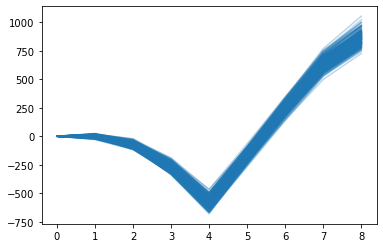

In [11]:
for i in range(N):
    plt.plot(works[:,i], color=colors[0], alpha=0.3)

check to make sure the sequence of IW kT vals and kernel kT values are correct...

In [25]:
forward_works = works[4,:]
backward_works = works[-1,:] - forward_works

In [29]:
from melange_lite.utils.analysis import bootstrap, symmetric_f, symmetric_f_v2, free_energy, there_and_back_f

In [30]:
symmetric_f(forward_works, backward_works)

DeviceArray(-674.79344753, dtype=float64)

In [34]:
there_and_back_f(forward_works, backward_works)

DeviceArray(-676.17974189, dtype=float64)

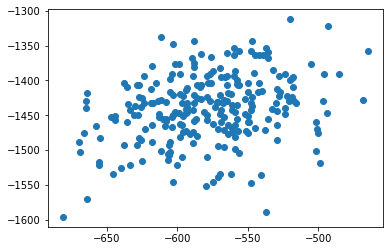

In [35]:
plt.scatter(forward_works, -backward_works)


# Variable T MCMC SMC Sampler with SYM and EXP
here, I'll look at the free energy MSE profile of the SYM and EXP (comparing with BAR from `vanilla` notebook)

In [66]:
N=10
L=32

import tqdm
Ts = [5, 50, 250, 500]
#Ts = [5,50]
forward_works = []
backward_works = []
direction = [0,1]
seed = random.PRNGKey(23423)
for i in range(len(Ts)):
    print(f"running time length {i}")
    T = Ts[i]
    kT_schedule = jnp.append(jnp.linspace(0,1,T), jnp.linspace(1,0,T)[1:])
    IW_parameters = jnp.hstack([jnp.ones(2*T - 1)[..., jnp.newaxis], #J
                                                                         jnp.zeros(2*T - 1)[..., jnp.newaxis], #h
                                                                         kT_schedule[..., jnp.newaxis] #beta
                                                                          ])
    smc_factory = TrainableIsingsModellSMCSampler(T=len(IW_parameters), 
                                              N=N, 
                                              IW_parameters= IW_parameters,
                                              L=L, 
                                              full_scan=True,
                                              MCMC=False
                                              )
    smc_work_fn = smc_factory.works()
    kernel_kT_schedule = jnp.append(jnp.linspace(0,1,T)[1:], jnp.linspace(1,0,T)[:-1])
    kernel_kT_schedule_len = len(kernel_kT_schedule)
    kernel_parameters = jnp.hstack([jnp.ones(kernel_kT_schedule_len)[..., jnp.newaxis], #J
                                    jnp.zeros(kernel_kT_schedule_len)[..., jnp.newaxis], #h
                                    kernel_kT_schedule[..., jnp.newaxis] #beta
                                   ])
    @jit
    def work_fn(seed):
        param_dict = {'seed': seed, 'kernel_parameters': kernel_parameters}
        wks = smc_work_fn(param_dict)
        cumulative_works = jnp.cumsum(wks, axis=0)
        forward_works = cumulative_works[T-1]
        backward_works = cumulative_works[-1] - forward_works
        return forward_works, backward_works
    
    fwd_run_list, bkwd_run_list = [], []
    for q in tqdm.trange(10):
        run_seed, seed = random.split(seed)
        fwd_works, bkwd_works = work_fn(run_seed)
        fwd_run_list.append(fwd_works)
        bkwd_run_list.append(bkwd_works)
    forward_works.append(np.array(fwd_run_list).flatten())
    backward_works.append(np.array(bkwd_run_list).flatten())
    

  0%|          | 0/10 [00:00<?, ?it/s]

running time length 0


  0%|          | 0/10 [00:00<?, ?it/s]

running time length 1


  0%|          | 0/10 [00:00<?, ?it/s]

running time length 2


  0%|          | 0/10 [00:00<?, ?it/s]

running time length 3


100%|██████████| 10/10 [01:54<00:00, 11.42s/it]


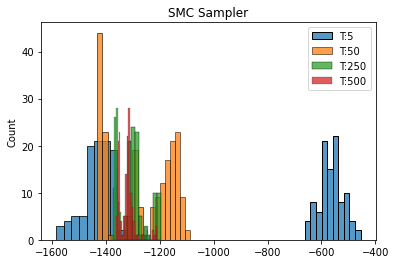

In [72]:
for i in range(len(Ts)):
    T = Ts[i]
    sns.histplot(forward_works[i], color = colors[i], label=f"T:{T}")
    sns.histplot(-backward_works[i], color=colors[i])
plt.title("SMC Sampler")
plt.legend()

In [74]:
symm, exp_fwd, tb = [], [], []
for i in range(len(Ts)):
    print(i)
    _fwd_work, _bkwd_work = forward_works[i], backward_works[i]
    interim_symm, interim_exp_fwd, interim_tb = [], [], []
    for i in range(1000):
        indices = np.random.choice(range(len(_fwd_work)), len(_fwd_work))
        fwd_work = _fwd_work[indices]
        bkwd_work = _bkwd_work[indices]
        exp_f = free_energy(fwd_work)
        _symm = symmetric_f(fwd_work, bkwd_work)
        _tb = there_and_back_f(fwd_work, bkwd_work)
        interim_symm.append(_symm)
        interim_exp_fwd.append(exp_f)
        interim_tb.append(_tb)
    symm.append(np.array(interim_symm))
    exp_fwd.append(np.array(interim_exp_fwd))
    tb.append(interim_tb)
    

0
1
2
3


In [80]:
MSE = lambda x: (true_f - np.mean(x))**2 + np.var(x)

In [81]:
true_f = -1339.27 # (cite)

In [82]:
symm_MSEs = np.array([MSE(x) for x in symm])
exp_fwd_MSEs = np.array([MSE(x) for x in exp_fwd])
tb_MSEs = np.array([MSE(x) for x in tb])

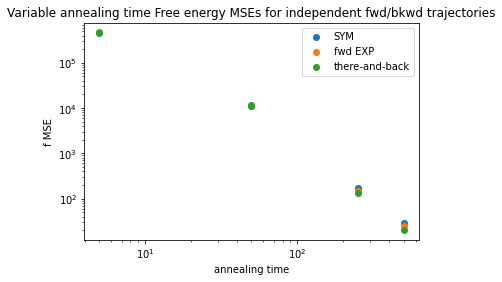

In [87]:
for i in range(len(Ts)):
    plt.scatter(Ts[i], symm_MSEs[i], color=colors[0], label='SYM' if i==len(Ts)-1 else None)
    plt.scatter(Ts[i], exp_fwd_MSEs[i], color=colors[1], label='fwd EXP' if i==len(Ts)-1 else None)
    plt.scatter(Ts[i], tb_MSEs[i], color = colors[2], label='there-and-back' if i==len(Ts)-1 else None)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(f"annealing time")
plt.ylabel("f MSE")
plt.title("Variable annealing time Free energy MSEs for independent fwd/bkwd trajectories")
plt.legend()